# 4. Theoretical Solutions


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab, need to install multitaper')
  %pip install multitaper

from multitaper import mtspec
from multitaper import mtcross

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


We now have everythign in place to theoretically compute the spectrum
of Hasselmann-type models. 

## Power Spectrum of the standard Hasselmann Model.

Let's first solve for the theoretical spectrum of a Hasselmann model,
and compare it with a simulation of the Hasselmann model using a time-step
$\Delta t$. Remember, the Hasselmann model is

$$
C\frac{dT}{dt}=-\lambda T+F
$$

where $F$ is white noise (at least at frequencies lower than the
sampling frequency $\left|f\right|<f_{N}=1/\left(2\Delta t\right)$).

The power spectrum of the Hasselmann model can be solved for by taking
the Fourier transform of the differential equation:

$$
i\omega C\tilde{T}\left(\omega\right)=-\lambda\tilde{T}\left(\omega\right)+\tilde{F}\left(\omega\right)
$$

$$
\tilde{T}\left(\omega\right)=\frac{\tilde{F}\left(\omega\right)}{\lambda+i\omega C}
$$

$$
\tilde{T}\left(\omega\right)=\frac{1}{\lambda}\frac{\tilde{F}\left(\omega\right)}{1+i\omega\tau_{0}}
$$

The spectrum can be computed as:

$$
S_{TT}\left(\omega\right)=\left\langle \tilde{T}\left(\omega\right)\tilde{T}\left(\omega\right)^{*}\right\rangle =\left\langle \frac{1}{\lambda}\frac{\tilde{F}\left(\omega\right)}{1+i\omega\tau_{0}}\frac{1}{\lambda}\frac{\tilde{F}^{*}\left(\omega\right)}{1-i\omega\tau_{0}}\right\rangle =\frac{1}{\lambda^{2}}\frac{\left\langle \tilde{F}\left(\omega\right)\tilde{F}^{*}\left(\omega\right)\right\rangle }{1+\omega^{2}\tau_{0}^{2}}
$$

$$
S_{TT}\left(\omega\right)=\frac{S_{FF}\left(\omega\right)}{\lambda^{2}}\frac{1}{1+\omega^{2}\tau_{0}^{2}}
$$

Using the fact that a white-noise process has a constant spectral
variance density:

$$
S_{FF}\left(\omega\right)=\tilde{s}_{F}^{2}
$$

we can write the spectrum of a Hasselmann model forced with white noise as: 

$$
S_{TT}\left(\omega\right)=\frac{\tilde{s}_{F}^{2}}{\lambda^{2}}\frac{1}{1+\omega^{2}\tau_{0}^{2}}=\frac{\tilde{s}_{F}^{2}}{\lambda^{2}+\omega^{2}C^{2}}
$$

If we want to check this spectrum against a numerical simulation where
we used a time-step of $\Delta t$ and set a variance $\sigma_{F}$
for the forcing vector $F_{n}$, we can write:

$$
\boxed{S_{TT}\left(\omega\right)=\frac{\sigma_{F}^{2}\Delta t}{\lambda^{2}}\frac{1}{1+\omega^{2}\tau_{0}^{2}}=\frac{\sigma_{F}^{2}\Delta t}{\lambda^{2}+\omega^{2}C{}^{2}}}
$$

Writing it in this way is also useful if, say, we want to model the spectrum
of monthly surface temperatures as a function of the variance of monthly
variations in surface heat flux forcing

Text(0, 0.5, '$S_{TT}$')

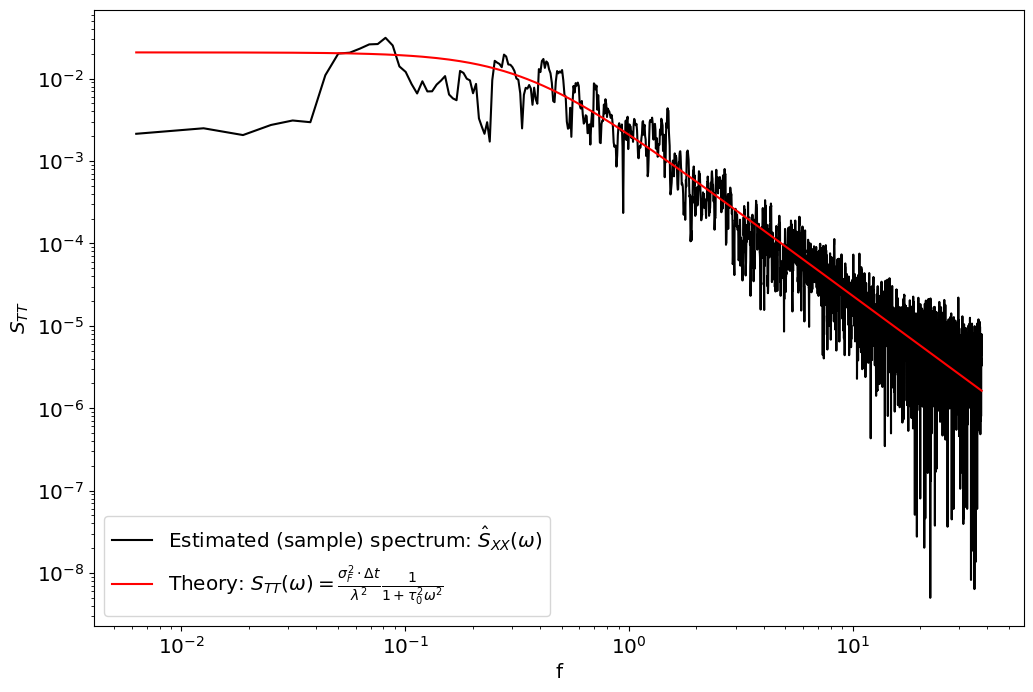

In [9]:
plt.figure(figsize=[12,8])

#physical parameters:
sigma_F=1;
tau=3;
l=2;
C=tau*l;

# numerical parameters 
dt=1/12
T=500

#compute other required variables
t=np.arange(0,T,dt)
N=len(t)
phi=1-(dt*l/C);

#white noise forcing 
F=stats.norm.rvs(loc=0,scale=sigma_F,size=N)
eps=F*dt/C

#integrate
T=np.zeros(N)
for j in range(1,N):
    T[j]=phi*T[j-1]+eps[j]

#compute spectrum
out=mtspec.MTSpec(T,nw=2,dt=dt,kspec=3)
f=out.freq
S_TT=out.spec
S_TT=S_TT[f>0]
f=f[f>0]

#theory
S_TT_theory=sigma_F**2*dt/(l**2) * 1/(1+(tau**2)*(2*np.pi*f)**2)

#plot
plt.plot(2*np.pi*f,S_TT,'k',label=r'Estimated (sample) spectrum: $\hat S_{XX}(\omega)$')
plt.plot(2*np.pi*f,S_TT_theory,'r',label=r'Theory: $S_{TT}(\omega)=\frac{\sigma_{F}^{2}\cdot\Delta t}{\lambda^{2}}\frac{1}{1+\tau_{0}^{2}\omega^{2}}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'f')
plt.ylabel(r'$S_{TT}$')

### Asymptotic behaviour

In the limit of high frequencies (short time-scales): $\omega\gg\tau_{0}$.
i.e. $f\gg\frac{1}{2\pi\tau_{0}}$ the dominant balance in the denominator
becomes $\omega^{2}\tau_{0}^{2}\gg1$ and the power spectrum asymptomes
to $S_{TT}\sim\frac{\tilde{s}_{F}^{2}}{\lambda^{2}\tau_{0}^{2}}\frac{1}{\omega^{2}}$
which obbeys a power law scaling of $S_{TT}\sim f^{-2}$ or $\omega^{-2}$. 

In the limit of low frequencies (long time-scales): $\omega\ll\tau_{0}$.
i.e. $f\ll\frac{1}{2\pi\tau_{0}}$ , the dominant balance is reversed,
with $1\gg\omega\tau_{0}^{2}$ and the spectrum asymptotes to: $S_{TT}\left(\omega\right)\sim\frac{\tilde{s}_{F}^{2}}{\lambda^{2}\tau_{0}^{2}}$ 

As you can see from the figure above there are essentially two pieces of
information in the spectrum: the spectral density at which it tapers
of, which gives us an estimate for $\tilde{s}_{F}^{2}/\lambda^{2}$
and the characteristic time-scale $\tau_{0}$, identifiable from the
roll-off frequency. Only having information about the power-spectrum
of temperature does not allow us to constrain both the variance of
the forcing, $\sigma_{F}^{2}$ \emph{and }the feedback $\lambda$,
only their ratio.

### Power Spectrum of surface heat fluxes:

In practice we may also have measurements of the net heat flux $Q=-\lambda T+F$.
The spectrum of $Q$ will be:

$$
\tilde{Q}\left(\omega\right)=-\frac{1}{1+i\omega\tau_{0}}\tilde{F}\left(\omega\right)+\tilde{F}\left(\omega\right)
$$

$$
\tilde{Q}\left(\omega\right)=\frac{i\omega\tau_{0}}{1+i\omega\tau_{0}}\tilde{F}\left(\omega\right)
$$

$$
S_{QQ}\left(\omega\right)=\tilde{s}_{F}^{2}\frac{\omega^{2}\tau_{0}^{2}}{1+\omega^{2}\tau_{0}^{2}}
$$

Between the estimate of two spectra, $S_{TT}$ and $S_{QQ}$, we now
have enough pieces of information to constrain all of $\lambda,\tau_{0}$
and $\sigma_{F}^{2}$. 


Text(0, 0.5, '$S_{QQ}$')

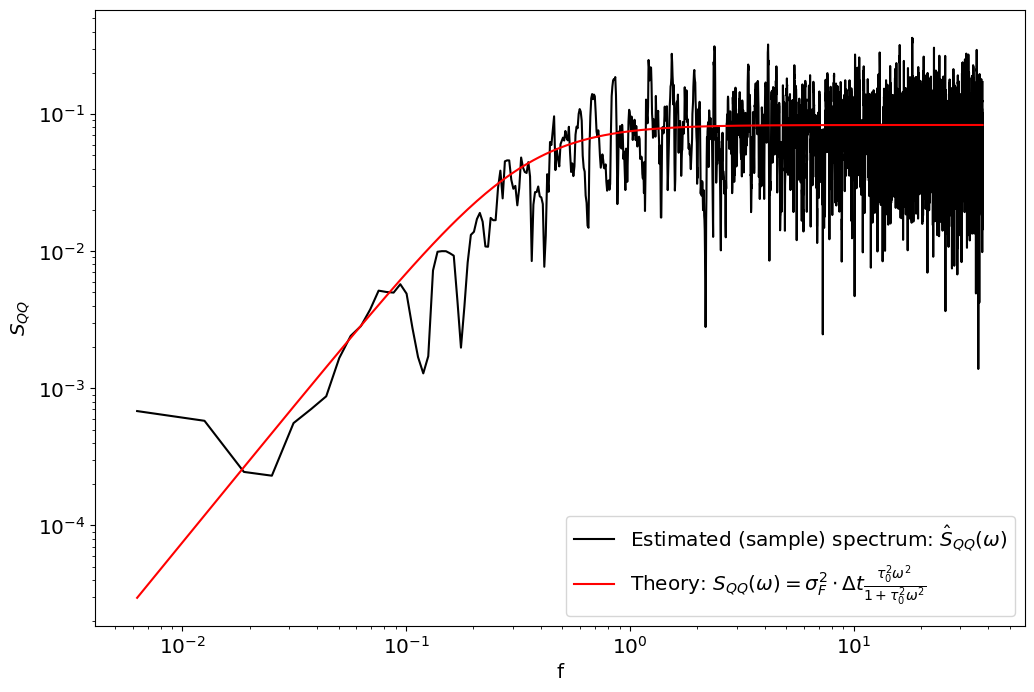

In [4]:
#compute spectrum
Q=-l*T+F
out_Q=mtspec.MTSpec(Q,nw=2,dt=dt,kspec=3)
f=out_Q.freq
S_QQ=out_Q.spec
S_QQ=S_QQ[f>0]
f=f[f>0]

#theory
S_QQ_theory=sigma_F**2*dt * ((tau**2)*(2*np.pi*f)**2)/(1+(tau**2)*(2*np.pi*f)**2)

#plot
plt.plot(2*np.pi*f,S_QQ,'k',label=r'Estimated (sample) spectrum: $\hat S_{QQ}(\omega)$')
plt.plot(2*np.pi*f,S_QQ_theory,'r',label=r'Theory: $S_{QQ}(\omega)=\sigma_{F}^{2}\cdot\Delta t\frac{\tau_{0}^{2}\omega^{2}}{1+\tau_{0}^{2}\omega^{2}}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('f')
plt.ylabel(r'$S_{QQ}$')


## Cross Spectrum of the standard Hasselmann Model

We can also can estimate cross power spectral density, such as $S_{QT}$. 

$$
\begin{cases}
C\frac{dT}{dt}=-\lambda T+F\\
Q=-\lambda T+F
\end{cases}
$$

$$
\begin{cases}
\tilde{T}\left(\omega\right)=\frac{1}{\lambda}\frac{1}{1+i\omega\tau_{0}}\tilde{F}\left(\omega\right)\\
\tilde{Q}\left(\omega\right)=-\frac{1}{1+i\omega\tau_{0}}\tilde{F}\left(\omega\right)+\tilde{F}\left(\omega\right)
\end{cases}
$$

$$
\begin{cases}
\tilde{T}\left(\omega\right)=\frac{1}{\lambda}\frac{1}{1+i\omega\tau_{0}}\tilde{F}\left(\omega\right)\\
\tilde{Q}\left(\omega\right)=\frac{i\omega\tau_{0}}{1+i\omega\tau_{0}}\tilde{F}\left(\omega\right)
\end{cases}
$$

$$
S_{QT}=\left\langle QT\right\rangle =\frac{\tilde{s}_{F}^{2}}{\lambda}\frac{i\omega\tau_{0}}{1+\omega^{2}\tau_{0}^{2}}
$$

The relation between two variables is also often estimated as the
transfer function: 

$$
H_{QT}=\frac{S_{QT}}{S_{TT}}=\lambda i\omega\tau_{0}
$$




## A model with two different sources of forcing:

Now consider a Hasselmann model with two different sources of forcing
and feedbacks, modelling the interaction of the mixed layer with both
the atmosphere and the ocean. For starteres, let's assume that the
mixed layer temperature does not feed-back onto the ocean:

$$
\begin{cases}
C\frac{dT}{dt}=-\lambda_{a}T+F_{a}+F_{o} & \text{mixed layer energy budget}\\
Q_{a}=-\lambda_{a}T+F_{a} & \text{atmospheric heat fluxes}
\end{cases}
$$

$$
\tilde{T}\left(\omega\right)=\frac{1}{\lambda_{a}}\frac{\tilde{F}_{a}\left(\omega\right)+\tilde{F}_{o}\left(\omega\right)}{1+i\omega\tau_{0}}
$$

$$
S_{TT}=\left\langle \tilde{T}\left(\omega\right)\tilde{T}^{*}\left(\omega\right)\right\rangle 
$$

Using the linearity property of the angle bracket operator, the above
equation can be written as:

$$
S_{TT}=\frac{1}{\lambda_{a}}\frac{\left\langle \tilde{F}_{a}\tilde{F}_{a}^{*}\right\rangle +\left\langle \tilde{F}_{a}\tilde{F}_{o}^{*}\right\rangle +\left\langle \tilde{F}_{o}\tilde{F}_{a}^{*}\right\rangle +\left\langle \tilde{F}_{o}\tilde{F}_{o}^{*}\right\rangle }{1+\omega^{2}\tau_{0}^{2}}
$$

Since $F_{a}$and $F_{o}$ are assumed to be white noise and independent
processes, $\left\langle \tilde{F}_{a}\tilde{F}_{o}^{*}\right\rangle =\left\langle \tilde{F}_{o}\tilde{F}_{a}^{*}\right\rangle =0$,
and the equation simplifies to:

$$
S_{TT}=\frac{1}{\lambda_{a}}\frac{\tilde{s}_{F_{a}}^{2}+\tilde{s}_{F_{o}}^{2}}{1+\omega^{2}\tau_{0}^{2}}
$$

$$
Q=-\lambda_{a}\tilde{T}\left(\omega\right)+F_{a}=-\frac{\tilde{F}_{a}\left(\omega\right)+\tilde{F}_{o}\left(\omega\right)}{1+i\omega\tau_{0}}+\tilde{F}_{a}
$$

$$
=\frac{i\omega\tau_{0}\tilde{F}_{a}\left(\omega\right)-\tilde{F}_{o}\left(\omega\right)}{1+i\omega\tau_{0}}
$$
With spectrum

$$
S_{QQ}=\left\langle QQ^{*}\right\rangle =\frac{1}{1+\omega^{2}\tau_{0}^{2}}\frac{\omega^{2}\tau^{2}\left\langle \tilde{F}_{a}\tilde{F}_{a}^{*}\right\rangle +i\omega\tau_{0}\left\langle \tilde{F}_{a}\tilde{F}_{o}^{*}\right\rangle +i\omega\tau_{o}\left\langle \tilde{F}_{o}\tilde{F}_{a}^{*}\right\rangle +\left\langle \tilde{F}_{o}\tilde{F}_{o}^{*}\right\rangle }{1+\omega^{2}\tau_{0}^{2}}
$$

$$
S_{TT}=\frac{\omega^{2}\tau_{0}^{2}\tilde{s}_{F_{a}}^{2}+\tilde{s}_{F_{o}}^{2}}{1+\omega^{2}\tau_{0}^{2}}
$$
and cross spectrum:

$$
S_{QT}=\left\langle QT\right\rangle =\frac{1}{\lambda_{a}}\frac{1}{1+\omega^{2}\tau_{0}^{2}}\frac{i\omega\tau_{0}\left\langle \tilde{F}_{a}\tilde{F}_{a}^{*}\right\rangle +i\omega\tau_{0}\left\langle \tilde{F}_{a}\tilde{F}_{o}^{*}\right\rangle -\left\langle \tilde{F}_{o}\tilde{F}_{a}^{*}\right\rangle -\left\langle \tilde{F}_{o}\tilde{F}_{o}^{*}\right\rangle }{1+\omega^{2}\tau_{0}^{2}}
$$

$$
S_{QT}=\frac{1}{\lambda_{a}}\frac{i\omega\tau_{0}\tilde{s}_{F_{a}}^{2}-\tilde{s}_{F_{o}}^{2}}{1+\omega^{2}\tau_{0}^{2}}
$$

leading to the transfer function:

$$
H_{QT}=\frac{S_{QT}}{S_{TT}}=\lambda_{a}\frac{i\omega\tau_{0}\tilde{s}_{F_{a}}^{2}-\tilde{s}_{F_{o}}^{2}}{\tilde{s}_{F_{a}}^{2}+\tilde{s}_{F_{o}}^{2}}
$$




## To do:

### Numerical Check

Check the theoretical solutions for a model with two sources of forcing numerically, and fix any errors (I expect a few sign errors at the very least). 

### Ocean and atmospheric heat fluxes and forcing

$$
\begin{cases}
C\frac{dT}{dt}=-\lambda_{a}T-\lambda_{0}T+F_{a}+F_{o} & \text{mixed layer energy budget}\\
Q_{a}=-\lambda_{a}T+F_{a} & \text{atmospheric heat fluxes}\\
Q_{o}=-\lambda_{o}T+F_{o} & \text{ocean heat fluxes}
\end{cases}
$$

Compute the power spectra and cross-spectra:

$$
S_{TT},S_{Q_{a}Q_{a}},S_{Q_{o}Q_{o}},S_{Q_{o}T},S_{Q_{a}T}
$$

as a function of parameters $\theta=\left[C,\lambda_{a},\lambda_{o},\tilde{s}_{F_{a}},\tilde{s}_{F_{o}}\right]$
. Note that since there are two feedbacks, we can no longer define
a single characteristic time-scale $\tau_{0}$, so we should write
these in terms of $C$. 

### Red noise ocean process

Now let's assume that ocean forcing is not white, but red. in other
words, 

$$
S_{F_{o}F_{o}}=\tilde{s}_{\eta}\frac{1}{1+\omega^{2}\tau_{1}^{2}}
$$
What are the spectra? 
$$
S_{TT},S_{Q_{a}Q_{a}},S_{Q_{o}Q_{o}},S_{Q_{o}T},S_{Q_{a}T}
$$
Simulate these numerically to check that the theoretical solutions
are accurate. Try different values of $\tau_{1}$ relative to $C/\lambda_{a}$
and $C/\lambda_{o}$. Note that you will need to simulate a red noise
forcing. You can do that by assuming that $F_{o}$ is itself a Hasselmann
model:

$$
\tau\frac{dF_{o}}{dt}=-F_{o}+\eta
$$
where $\eta$ is white noise. 